<a href="https://colab.research.google.com/github/ItalianPepper/coronavirus_ita_svr/blob/master/coronavirus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

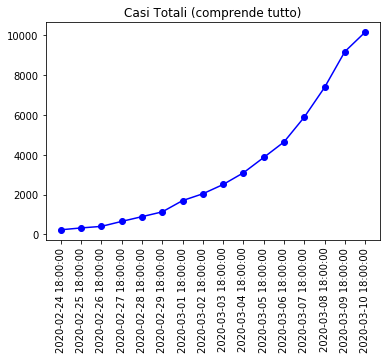

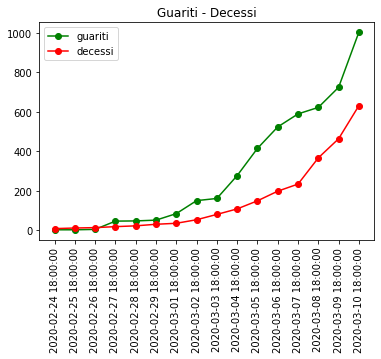

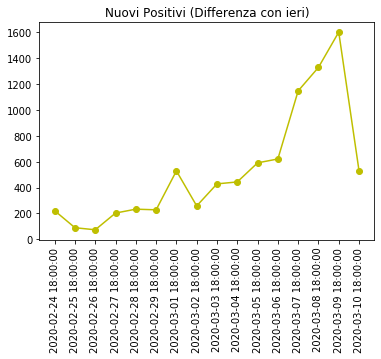

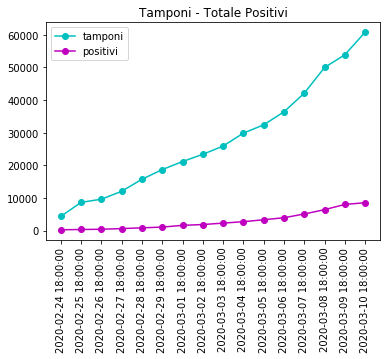

Siate responsabili e osservate le normative del governo italiano.
Le previsioni considerano l'andamento del virus negli ultimi 7 giorni.
Le previsioni sono soggette ad oscillazioni.
---
Previsioni Numero di Casi
Ultimo aggiornamento del  2020-03-10 18:00:00 :  10149
Previsione per domani: 12728
Previsione per dopodomani: 15539
Previsione fra 3 giorni: 19519
---
---
Previsioni Guariti
Ultimo aggiornamento del  2020-03-10 18:00:00 :  1004
Previsione per domani: 1884
Previsione per dopodomani: 3681
Previsione fra 3 giorni: 6257
---
---
Previsioni Decessi
Ultimo aggiornamento del  2020-03-10 18:00:00 :  631
Previsione per domani: 1011
Previsione per dopodomani: 1074
Previsione fra 3 giorni: 1719
---


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [17]:
import urllib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
import numpy as np
import os.path

# Download .csv file from official profile of Protezione Civile.
raw_git_url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
csv_name = "dpc-covid19-ita-andamento-nazionale.csv"
urllib.request.urlretrieve(raw_git_url, csv_name)


df_ita_covid = pd.read_csv(csv_name, sep=",", header=0)
tot_casi_col = df_ita_covid["totale_casi"].tolist()
tot_healed_col = df_ita_covid["dimessi_guariti"].tolist()
tot_deaths_col = df_ita_covid["deceduti"].tolist()
dates_col = df_ita_covid["data"].tolist()
new_cases_col = df_ita_covid["nuovi_attualmente_positivi"].tolist()
tot_now_positive_col = df_ita_covid["totale_attualmente_positivi"].tolist()
tot_tamponi_col = df_ita_covid["tamponi"].tolist()

last_date = dates_col[len(dates_col)-1]

# Plotting time series total cases
plt.plot_date(dates_col, tot_casi_col, 'ob-', xdate=True, )
plt.title("Casi Totali (comprende tutto)")
plt.xticks(rotation=90)
plt.show()
plt.close()

#Plotting time series togheter
plt.plot_date(dates_col, tot_healed_col, 'og-', xdate=True)
plt.plot_date(dates_col, tot_deaths_col, 'or-', xdate=True)
plt.title("Guariti - Decessi")
plt.legend(["guariti", "decessi"])
plt.xticks(rotation=90)
plt.show()
plt.close()


#Plotting time series new positives
plt.plot_date(dates_col, new_cases_col, 'oy-', xdate=True)
plt.title("Nuovi Positivi (Differenza con ieri)")
plt.xticks(rotation=90)
plt.show()
plt.close()

# Plotting tamponi - Actual positives
plt.plot_date(dates_col, tot_tamponi_col, 'oc-', xdate=True)
plt.plot_date(dates_col, tot_now_positive_col, 'om-', xdate=True)
plt.title("Tamponi - Totale Positivi")
plt.legend(["tamponi", "positivi"])
plt.xticks(rotation=90)
plt.show()
plt.close()

"""
# Plotting time series total healed
plt.plot_date(dates_col, tot_healed_col, 'og-', xdate=True)
plt.title("Guariti")
plt.xticks(rotation=90)
plt.show()
plt.close()

#Plotting time series total deaths
plt.plot_date(dates_col, tot_deaths_col, 'or-', xdate=True)
plt.title("Decessi")
plt.xticks(rotation=90)
plt.show()
plt.close()
"""


def run_linear_svr(col_selected, last_date, title, look_back=1):

  x_mod = []
  y_mod = []

  for i in range(look_back, len(col_selected)):
    
    # Example look_back = 3:
    # -> i = 3:
    # x = {v[0], v[1], v[2]}
    # y = {v[3]}
    #
    # -> i = 4:
    # x = {v[1], v[2], v[3]}
    # y = {v[4]}
    # ecc...

    x_sample = col_selected[i-look_back:i]
    
    y_sample = col_selected[i]
    
    x_mod.append(x_sample)
    y_mod.append(y_sample)

  # That's the formula for the next day prediction:
  # X for next predictions is equal to last element of train set less the first
  # element of that vector. Then adding the last value of y.
  x_tmp = x_mod[len(x_mod)-1]
  y_tmp = y_mod[len(y_mod)-1]
  last_x = [x_tmp[i] for i in range(1, look_back)]
  last_x.append(y_tmp)


  # Transforming in np.array
  last_x_arr = np.array(last_x).reshape(1, look_back)
  x = np.array(x_mod).reshape(-1, look_back)
  y = np.array(y_mod)

  svr = LinearSVR(epsilon=0.001, max_iter=10000)
  svr.fit(x, y)

  print("---")
  print(title)
  
  print("Ultimo aggiornamento del ", last_date, 
        ": ",col_selected[len(col_selected)-1])

  prediction = svr.predict(last_x_arr)
  round_prediction = int(prediction)

  print("Previsione per domani:", round_prediction)

  # Removing the first element from last_x and
  # adding at end the last prediction.
  # to create the next 2nd prediction (the day after tomorrow)

  sec_day_after = [last_x[i] for i in range(1, len(last_x))]
  sec_day_after.append(round_prediction)

  sec_day_after_arr = np.array(sec_day_after).reshape(1, look_back)
  prediction_sec = svr.predict(sec_day_after_arr)
  round_prediction_sec = int(prediction_sec)

  print("Previsione per dopodomani:", round_prediction_sec)

  thr_day_after = [sec_day_after[i] for i in range(1, len(sec_day_after))]
  thr_day_after.append(round_prediction_sec)

  thr_day_after_arr = np.array(thr_day_after).reshape(1, look_back)
  prediction_thr = svr.predict(thr_day_after_arr)
  round_prediction_thr = int(prediction_thr)

  print("Previsione fra 3 giorni:", round_prediction_thr)
  print("---")

print("Siate responsabili e osservate le normative del governo italiano.")
print("Le previsioni considerano l'andamento del virus negli ultimi 7 giorni.")
print("Le previsioni sono soggette ad oscillazioni.")

run_linear_svr(tot_casi_col, last_date, "Previsioni Numero di Casi", look_back=7)
run_linear_svr(tot_healed_col, last_date, "Previsioni Guariti", look_back=7)
run_linear_svr(tot_deaths_col, last_date, "Previsioni Decessi", look_back=7)

---
Vecchie previsioni
---
Dati aggiornati al 2020-03-08 18:00:00
---
Previsioni Numero di Casi

Ultimo aggiornamento del  2020-03-09 18:00:00 :  9172

Previsione per domani: 11475

Previsione per dopodomani: 14448

Previsione fra 3 giorni: 17975

Previsioni Guariti

Ultimo aggiornamento del  2020-03-09 18:00:00 :  724

Previsione per domani: 818

Previsione per dopodomani: 1201

Previsione fra 3 giorni: 2169

Previsioni Decessi

Ultimo aggiornamento del  2020-03-09 18:00:00 :  463

Previsione per domani: 672

Previsione per dopodomani: 979

Previsione fra 3 giorni: 1182